In [654]:
import pandas as pd
import numpy as np
import pickle

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb, lightgbm as lgbm, catboost as catb

import seaborn as sns
import sklearn
import matplotlib 
from matplotlib import pyplot as plt
from scipy.stats import probplot
from sklearn.ensemble import RandomForestRegressor
%matplotlib inline

In [655]:
import warnings
warnings.filterwarnings('ignore')

In [656]:
matplotlib.rcParams.update({'font.size': 14})

### Описание датасета

In [657]:
#Мы имеем данные посетителей сайта gb
pd.set_option('display.max_colwidth', None)
df_descr = pd.read_excel('Описание полей.xlsx')
df_descr

,Поле,Описание
0,session_id,идентификатор сессии
1,claim,"признак наличия отправки формы заявки во вемя текущей сессии (0 – нет заявки, 1 – заявка отправлена)"
2,60sec,"признак длительности сессии 60 секунд и более (0 – сессия менее 60 сек, 1 – сессия 60 сек и более)"
3,scroll_90,"признак вертикальной прокрутки страницы глубиной 90% (0 – прокрутка менее 90%, 1 – прокрутка 90% и более)"
4,hit_date,дата сессии
5,referer_url,адрес реферера страницы просмотра
6,url,адрес страницы просмотра
7,utm_source,utm-метка источника
8,utm_medium,utm-метка канала
9,gender,"пол посетителя из куки (-1 – не определен, 0 – мужской, 1 – женский)"


In [658]:
# Более наглядный вывод названий полей.
for index, row in df_descr.iterrows():
    print('Поле - ', row['Поле']+'\n'+'Значение - ', row['Описание'])

Поле -  session_id
Значение -  идентификатор сессии
Поле -  claim
Значение -  признак наличия отправки формы заявки во вемя текущей сессии (0 – нет заявки, 1 – заявка отправлена)
Поле -  60sec
Значение -  признак длительности сессии 60 секунд и более (0 – сессия менее 60 сек, 1 – сессия 60 сек и более)
Поле -  scroll_90
Значение -  признак вертикальной прокрутки страницы глубиной 90% (0 – прокрутка менее 90%, 1 – прокрутка 90% и более)
Поле -  hit_date
Значение -  дата сессии
Поле -  referer_url
Значение -  адрес реферера страницы просмотра
Поле -  url
Значение -  адрес страницы просмотра
Поле -  utm_source
Значение -  utm-метка источника
Поле -  utm_medium
Значение -  utm-метка канала
Поле -  gender
Значение -  пол посетителя из куки (-1 – не определен, 0 – мужской, 1 – женский)
Поле -  age
Значение -  возраст посетителя из куки (-1 – не определен)
Поле -  touch_screen
Значение -  touch экран (0 – не определен, 1 – нет, 2 – есть)
Поле -  has_vk_id
Значение -  наличие идентификатора пр

In [659]:
df = pd.read_csv('Датасет GB.csv')
df.head()

,session_id,claim,60sec,scroll_90,hit_date,referer_url,url,utm_source,utm_medium,gender,age,touch_screen,has_vk_id,has_ok_id
0,4358a11f0d16be6e,0,0,1,2021-12-01,https://gb.ru/education,https://gb.ru/comms/calendar,NaN,NaN,0,39,1,1,0
1,133509b7ff9a586c,0,0,0,2021-12-01,https://www.google.com/,https://gb.ru/courses/programming,google,cpc,-1,-1,2,0,0
2,8b23cd36f2b08dcd,0,0,0,2021-12-01,https://gb.ru/tests/352/trials/2238911/run,https://gb.ru/tests/352/trials/2238911,NaN,NaN,1,49,1,1,1
3,50de4c060fd128f3,0,1,1,2021-12-01,https://gb.ru/courses/1165,https://gb.ru/a/a1,NaN,NaN,-1,-1,1,1,0
4,c2ca3cc9a67c749b,0,0,0,2021-12-01,NaN,https://gb.ru/login,NaN,NaN,0,23,2,1,0


In [660]:
#пропуски: 
#utm_source    245184 non-null  object, нет больше половины значений - наверное уберу этот признак
#utm_medium    244863 non-null  objectб нет больше половины значений - наверное уберу этот признак
#referer_url   687598 non-null  object
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 884407 entries, 0 to 884406
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   session_id    884407 non-null  object
 1   claim         884407 non-null  int64 
 2   60sec         884407 non-null  int64 
 3   scroll_90     884407 non-null  int64 
 4   hit_date      884407 non-null  object
 5   referer_url   687598 non-null  object
 6   url           884407 non-null  object
 7   utm_source    245184 non-null  object
 8   utm_medium    244863 non-null  object
 9   gender        884407 non-null  int64 
 10  age           884407 non-null  int64 
 11  touch_screen  884407 non-null  int64 
 12  has_vk_id     884407 non-null  int64 
 13  has_ok_id     884407 non-null  int64 
dtypes: int64(8), object(6)
memory usage: 94.5+ MB


In [661]:
df.shape

(884407, 14)

In [662]:
#смотрим первую строку
df.iloc[0]

session_id                  4358a11f0d16be6e
claim                                      0
60sec                                      0
scroll_90                                  1
hit_date                          2021-12-01
referer_url          https://gb.ru/education
url             https://gb.ru/comms/calendar
utm_source                               NaN
utm_medium                               NaN
gender                                     0
age                                       39
touch_screen                               1
has_vk_id                                  1
has_ok_id                                  0
Name: 0, dtype: object

In [663]:
df.describe()

,claim,60sec,scroll_90,gender,age,touch_screen,has_vk_id,has_ok_id
count,884407.000000,884407.000000,884407.000000,884407.000000,884407.000000,884407.000000,884407.000000,884407.000000
mean,0.002071,0.313425,0.144197,-0.359456,14.844552,1.436307,0.449500,0.124044
std,0.045466,0.463886,0.351290,0.808853,21.505421,0.495927,0.497444,0.329631
min,0.000000,0.000000,0.000000,-1.000000,-1.000000,1.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,-1.000000,-1.000000,1.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,-1.000000,-1.000000,1.000000,0.000000,0.000000
75%,0.000000,1.000000,0.000000,0.000000,29.000000,2.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,120.000000,2.000000,1.000000,1.000000


#### Промежуточный вывод

Из предложенных данных для задачи регрессии подходит только **возраст**. Изучим данную целевую переменную.

In [664]:
# 10  age   884407 non-null  int64 
df.age.value_counts()

-1     505397
 23     15155
 21     15119
 27     13601
 31     13571
        ...  
 2         20
 6         14
 3         10
 4          9
 5          3
Name: age, Length: 121, dtype: int64

### Вывод

У нас 505397 наблюдений со значением -1, а всего значений 884407. Получается больше половины данных нет (если бы -1 было немного - можно было бы просто убрать эти строки и работать с известными данными).

Соответственно мы не сможем выполнить задачу регресии.

Будем выполнять задачу **классификации**.

Будем предсказывать параметр:

Поле -  **claim**

Значение -  **признак наличия отправки формы заявки во вемя текущей сессии (0 – нет заявки, 1 – заявка отправлена)**

Предполагаем, что для сайта это наиболее важно, была отправлена заявка или нет. Попробуем предсказать эти данные. 

### EDA и преобразование данных

In [665]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 884407 entries, 0 to 884406
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   session_id    884407 non-null  object
 1   claim         884407 non-null  int64 
 2   60sec         884407 non-null  int64 
 3   scroll_90     884407 non-null  int64 
 4   hit_date      884407 non-null  object
 5   referer_url   687598 non-null  object
 6   url           884407 non-null  object
 7   utm_source    245184 non-null  object
 8   utm_medium    244863 non-null  object
 9   gender        884407 non-null  int64 
 10  age           884407 non-null  int64 
 11  touch_screen  884407 non-null  int64 
 12  has_vk_id     884407 non-null  int64 
 13  has_ok_id     884407 non-null  int64 
dtypes: int64(8), object(6)
memory usage: 94.5+ MB


In [666]:
df.isnull().sum()

session_id           0
claim                0
60sec                0
scroll_90            0
hit_date             0
referer_url     196809
url                  0
utm_source      639223
utm_medium      639544
gender               0
age                  0
touch_screen         0
has_vk_id            0
has_ok_id            0
dtype: int64

In [667]:
df.columns

Index(['session_id', 'claim', '60sec', 'scroll_90', 'hit_date', 'referer_url',
       'url', 'utm_source', 'utm_medium', 'gender', 'age', 'touch_screen',
       'has_vk_id', 'has_ok_id'],
      dtype='object')

In [668]:
#удалим столбцы session_id - так как он не несет смысловой нагрузки,
#а также utm_source и utm_medium так как в них пропущено больше половины значений
#также не будем использовать столбец referer_url
df_final = df[['session_id','60sec', 'scroll_90', 'hit_date', 'url', 'gender', 'age', 'touch_screen', 'has_vk_id', 'has_ok_id', 'claim']]
df_final.head()

,session_id,60sec,scroll_90,hit_date,url,gender,age,touch_screen,has_vk_id,has_ok_id,claim
0,4358a11f0d16be6e,0,1,2021-12-01,https://gb.ru/comms/calendar,0,39,1,1,0,0
1,133509b7ff9a586c,0,0,2021-12-01,https://gb.ru/courses/programming,-1,-1,2,0,0,0
2,8b23cd36f2b08dcd,0,0,2021-12-01,https://gb.ru/tests/352/trials/2238911,1,49,1,1,1,0
3,50de4c060fd128f3,1,1,2021-12-01,https://gb.ru/a/a1,-1,-1,1,1,0,0
4,c2ca3cc9a67c749b,0,0,2021-12-01,https://gb.ru/login,0,23,2,1,0,0


In [669]:
#пропусков нет
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 884407 entries, 0 to 884406
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   session_id    884407 non-null  object
 1   60sec         884407 non-null  int64 
 2   scroll_90     884407 non-null  int64 
 3   hit_date      884407 non-null  object
 4   url           884407 non-null  object
 5   gender        884407 non-null  int64 
 6   age           884407 non-null  int64 
 7   touch_screen  884407 non-null  int64 
 8   has_vk_id     884407 non-null  int64 
 9   has_ok_id     884407 non-null  int64 
 10  claim         884407 non-null  int64 
dtypes: int64(8), object(3)
memory usage: 74.2+ MB


In [670]:
df_final['url'].value_counts()

https://gb.ru/education                   150196
https://gb.ru/                            126766
https://gb.ru/s/edufree/besplatno         108939
https://gb.ru/login                        56082
https://gb.ru/courses                      17106
                                           ...  
https://gb.ru/tests/19/trials/2244143          1
https://gb.ru/tests/351/trials/2242842         1
https://gb.ru/tests/347/trials/2243842         1
https://gb.ru/geek_university/big              1
https://gb.ru/tests/287/trials/2247499         1
Name: url, Length: 13477, dtype: int64

In [671]:
#13477 уникальных ссылок
len(df_final['url'].unique())

13477

In [672]:
#данные несбалансированы
df_final['claim'].value_counts()

0    882575
1      1832
Name: claim, dtype: int64

In [673]:
#sns.barplot(data=df_final, x='claim', y='session_id')

In [674]:
df_final['60sec'].value_counts()

0    607212
1    277195
Name: 60sec, dtype: int64

In [675]:
df_final['scroll_90'].value_counts()

0    756878
1    127529
Name: scroll_90, dtype: int64

In [676]:
df_final['gender'].value_counts()

-1    505397
 0    191518
 1    187492
Name: gender, dtype: int64

In [677]:
#изучим дубликаты
dup = df_final[df_final.duplicated()].shape[0]
print(f"Всего {dup} дубликатов из {df_final.shape[0]} наблюдений датасета.")

df_final.drop_duplicates(keep='first',inplace=True)
print(f"\nПосле удаления дубликатов осталось {df_final.shape[0]} наблюдений в датасете.")

Всего 1 дубликатов из 884407 наблюдений датасета.

После удаления дубликатов осталось 884406 наблюдений в датасете.


<AxesSubplot:title={'center':'Распределения возраста посетителей сайта'}, xlabel='age', ylabel='Density'>

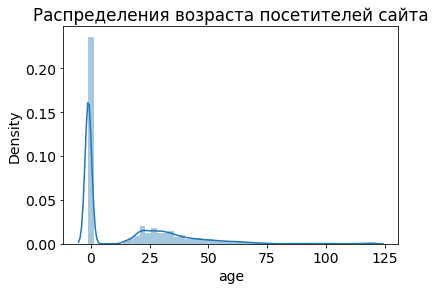

In [678]:
plt.title('Распределения возраста посетителей сайта')
sns.distplot(df_final['age'])

In [679]:
df_copy = df_final.copy()
df_claim_pos = df_copy[df_copy["claim"] == 1]
df_claim_pos.head()

,session_id,60sec,scroll_90,hit_date,url,gender,age,touch_screen,has_vk_id,has_ok_id,claim
1636,05d4fa30dc5536a5,1,1,2021-12-01,https://gb.ru/geek_university/system-business-analysis,-1,-1,1,0,0,1
2461,96dea6adb91d26ec,1,0,2021-12-01,https://gb.ru/professions/game_developer,-1,-1,1,0,0,1
3927,7330d083db99b137,1,0,2021-12-01,https://gb.ru/courses/geek-school/java,-1,-1,1,0,0,1
4334,53525af7214d57c2,1,0,2021-12-01,https://gb.ru/courses/geek-school/aibasic,-1,-1,1,0,0,1
4340,fa29708b23d87438,1,0,2021-12-01,https://gb.ru/geek_university/system-business-analysis,-1,-1,2,0,0,1


In [680]:
df_claim_pos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1832 entries, 1636 to 884060
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   session_id    1832 non-null   object
 1   60sec         1832 non-null   int64 
 2   scroll_90     1832 non-null   int64 
 3   hit_date      1832 non-null   object
 4   url           1832 non-null   object
 5   gender        1832 non-null   int64 
 6   age           1832 non-null   int64 
 7   touch_screen  1832 non-null   int64 
 8   has_vk_id     1832 non-null   int64 
 9   has_ok_id     1832 non-null   int64 
 10  claim         1832 non-null   int64 
dtypes: int64(8), object(3)
memory usage: 171.8+ KB


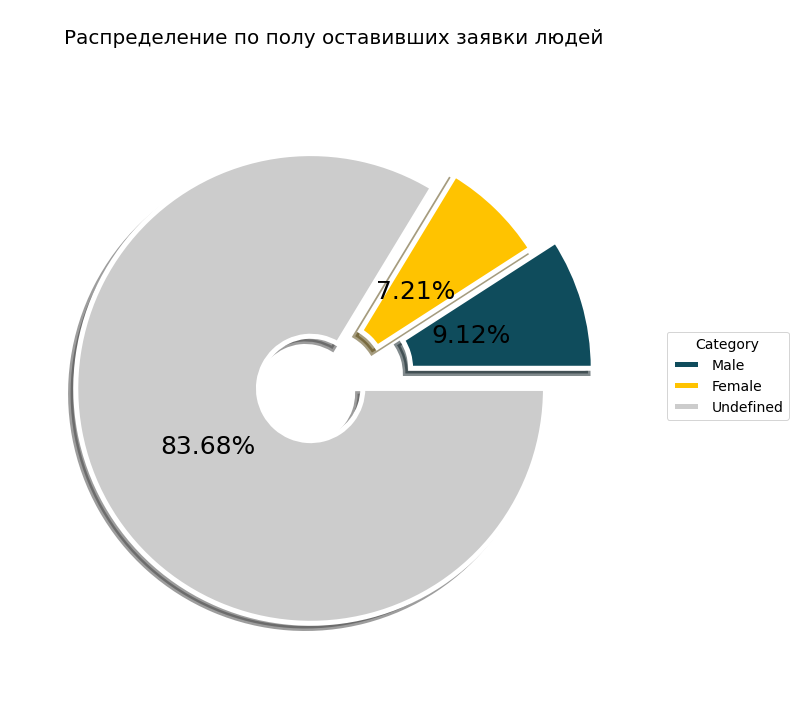

In [681]:
plt.subplots(figsize=(12, 12))

labels = "Male","Female","Undefined"
size = 0.7

wedges, texts, autotexts = plt.pie([len(df_claim_pos[df_claim_pos["gender"]== 0]["gender"]),
                                    len(df_claim_pos[df_claim_pos["gender"]== 1]["gender"]),
                                    len(df_claim_pos[df_claim_pos["gender"]== -1]["gender"])],
                                    explode = (0.1,0,0.1),
                                    textprops=dict(size= 25, color= "black"),
                                    autopct="%.2f%%", 
                                    pctdistance = 0.5,
                                    radius=.9, 
                                    colors = ["#0f4c5c","#FFC300", "#ccc"], 
                                    shadow = True,
                                    wedgeprops=dict(width = size, edgecolor = "white", 
                                    linewidth = 5),
                                    startangle = 0)

plt.legend(wedges, labels, title="Category",loc="center left",bbox_to_anchor=(1, 0, 0.5, 1))
plt.title("\nРаспределение по полу оставивших заявки людей",fontsize=20)
plt.show()

In [682]:
#превратим hit_date в формат datetime
df_final['hit_date'] = pd.to_datetime(df_final['hit_date'])
df_final.head()

,session_id,60sec,scroll_90,hit_date,url,gender,age,touch_screen,has_vk_id,has_ok_id,claim
0,4358a11f0d16be6e,0,1,2021-12-01,https://gb.ru/comms/calendar,0,39,1,1,0,0
1,133509b7ff9a586c,0,0,2021-12-01,https://gb.ru/courses/programming,-1,-1,2,0,0,0
2,8b23cd36f2b08dcd,0,0,2021-12-01,https://gb.ru/tests/352/trials/2238911,1,49,1,1,1,0
3,50de4c060fd128f3,1,1,2021-12-01,https://gb.ru/a/a1,-1,-1,1,1,0,0
4,c2ca3cc9a67c749b,0,0,2021-12-01,https://gb.ru/login,0,23,2,1,0,0


In [683]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 884406 entries, 0 to 884406
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   session_id    884406 non-null  object        
 1   60sec         884406 non-null  int64         
 2   scroll_90     884406 non-null  int64         
 3   hit_date      884406 non-null  datetime64[ns]
 4   url           884406 non-null  object        
 5   gender        884406 non-null  int64         
 6   age           884406 non-null  int64         
 7   touch_screen  884406 non-null  int64         
 8   has_vk_id     884406 non-null  int64         
 9   has_ok_id     884406 non-null  int64         
 10  claim         884406 non-null  int64         
dtypes: datetime64[ns](1), int64(8), object(2)
memory usage: 81.0+ MB


In [684]:
#создадим параметр url_popularity в который запишем частоту каждого url
#для этого сделаем группировку по url
group_df = df_final.groupby('url').count()['session_id']
group_df

url
content://downloads/all_downloads/385              1
file://                                           98
http://0.0.0.0:3000//basic-programming             1
http://0.0.0.0:3000//basic-programmings            3
http://0.0.0.0:3000/a/a1                           3
                                                  ..
https://videoediting.webflow.io/                   8
https://watson-api.yandex-team.ru/api/get_html     6
https://webcache.googleusercontent.com/search     11
https://www.geek.ms/                               2
https://yandexwebcache.net/yandbtm                 2
Name: session_id, Length: 13477, dtype: int64

In [685]:
group_dict = group_df.to_dict()
group_dict

{'content://downloads/all_downloads/385': 1,
 'file://': 98,
 'http://0.0.0.0:3000//basic-programming': 1,
 'http://0.0.0.0:3000//basic-programmings': 3,
 'http://0.0.0.0:3000/a/a1': 3,
 'http://0.0.0.0:3000/a/a2': 3,
 'http://0.0.0.0:3000/basic-programming': 5,
 'http://0.0.0.0:3000/basic_intensive': 1,
 'http://0.0.0.0:3000/basic_programming': 1,
 'http://0.0.0.0:3000/geek_university/faculties/programming': 2,
 'http://0.0.0.0:3000/geek_university/programming': 1,
 'http://0.0.0.0:3000/professions/android_developer': 1,
 'http://0.0.0.0:3000/static_pages/basic-programming': 1,
 'http://0.0.0.0:3000/static_pages/basic-programming/dsadsa/ds/a/dsa/d/sas/d/a/sa/d/asd/dsa//asd': 1,
 'http://0.0.0.0:3000/welcome/test/1': 1,
 'http://10.0.2.15/': 2,
 'http://10.10.0.117:3000/': 5,
 'http://10.10.0.117:3000/company': 1,
 'http://10.10.0.117:50471/': 2,
 'http://10.10.0.117:54925/': 4,
 'http://10.10.0.117:61184/': 2,
 'http://10.10.0.117:61184/company': 1,
 'http://10.10.0.117:61184/company/

In [686]:
df_final['url_popularity'] = df_final['url'].map(group_dict)
df_final.head()

,session_id,60sec,scroll_90,hit_date,url,gender,age,touch_screen,has_vk_id,has_ok_id,claim,url_popularity
0,4358a11f0d16be6e,0,1,2021-12-01,https://gb.ru/comms/calendar,0,39,1,1,0,0,6598
1,133509b7ff9a586c,0,0,2021-12-01,https://gb.ru/courses/programming,-1,-1,2,0,0,0,16008
2,8b23cd36f2b08dcd,0,0,2021-12-01,https://gb.ru/tests/352/trials/2238911,1,49,1,1,1,0,12
3,50de4c060fd128f3,1,1,2021-12-01,https://gb.ru/a/a1,-1,-1,1,1,0,0,5712
4,c2ca3cc9a67c749b,0,0,2021-12-01,https://gb.ru/login,0,23,2,1,0,0,56082


In [687]:
#также создадим подсказку для нашей модели
#сделаем параметр url_claim, в котором будем указывать сколько заявок было сделано по этому url
df_claim_pos

group_df_claim = df_claim_pos.groupby('url').count()['session_id']
group_df_claim 

url
https://gb.ru/a2leader                      12
https://gb.ru/courses/all/analytics          1
https://gb.ru/courses/all/creativeschool     4
https://gb.ru/courses/all/design            15
https://gb.ru/courses/all/hr                 1
                                            ..
https://gb.ru/professions/video-editing     18
https://gb.ru/professions/web-designer       9
https://gb.ru/professions/web_developer      5
https://gb.ru/promo/forbusiness              3
https://gb.ru/tests/careertest               1
Name: session_id, Length: 150, dtype: int64

In [688]:
group_dict_claim = group_df_claim .to_dict()
group_dict_claim

{'https://gb.ru/a2leader': 12,
 'https://gb.ru/courses/all/analytics': 1,
 'https://gb.ru/courses/all/creativeschool': 4,
 'https://gb.ru/courses/all/design': 15,
 'https://gb.ru/courses/all/hr': 1,
 'https://gb.ru/courses/all/it': 7,
 'https://gb.ru/courses/all/itforall': 2,
 'https://gb.ru/courses/all/teamlead/director-clients': 2,
 'https://gb.ru/courses/all/teamlead/hr': 1,
 'https://gb.ru/courses/character-design': 10,
 'https://gb.ru/courses/experts-school': 6,
 'https://gb.ru/courses/geek-school': 9,
 'https://gb.ru/courses/geek-school/': 8,
 'https://gb.ru/courses/geek-school/aibasic': 21,
 'https://gb.ru/courses/geek-school/animation': 26,
 'https://gb.ru/courses/geek-school/arduino': 20,
 'https://gb.ru/courses/geek-school/blogging': 24,
 'https://gb.ru/courses/geek-school/gamedev': 8,
 'https://gb.ru/courses/geek-school/graphics': 21,
 'https://gb.ru/courses/geek-school/infosecurity': 20,
 'https://gb.ru/courses/geek-school/java': 20,
 'https://gb.ru/courses/geek-school/lite

In [689]:
df_final['url_claim'] = 0
df_final['url_claim'] = df_final['url'].map(group_dict_claim)
df_final.head()

,session_id,60sec,scroll_90,hit_date,url,gender,age,touch_screen,has_vk_id,has_ok_id,claim,url_popularity,url_claim
0,4358a11f0d16be6e,0,1,2021-12-01,https://gb.ru/comms/calendar,0,39,1,1,0,0,6598,NaN
1,133509b7ff9a586c,0,0,2021-12-01,https://gb.ru/courses/programming,-1,-1,2,0,0,0,16008,NaN
2,8b23cd36f2b08dcd,0,0,2021-12-01,https://gb.ru/tests/352/trials/2238911,1,49,1,1,1,0,12,NaN
3,50de4c060fd128f3,1,1,2021-12-01,https://gb.ru/a/a1,-1,-1,1,1,0,0,5712,NaN
4,c2ca3cc9a67c749b,0,0,2021-12-01,https://gb.ru/login,0,23,2,1,0,0,56082,NaN


In [690]:
#заменим Nan
df_final['url_claim'].fillna(0, inplace=True)

In [691]:
df_final.head()

,session_id,60sec,scroll_90,hit_date,url,gender,age,touch_screen,has_vk_id,has_ok_id,claim,url_popularity,url_claim
0,4358a11f0d16be6e,0,1,2021-12-01,https://gb.ru/comms/calendar,0,39,1,1,0,0,6598,0.0
1,133509b7ff9a586c,0,0,2021-12-01,https://gb.ru/courses/programming,-1,-1,2,0,0,0,16008,0.0
2,8b23cd36f2b08dcd,0,0,2021-12-01,https://gb.ru/tests/352/trials/2238911,1,49,1,1,1,0,12,0.0
3,50de4c060fd128f3,1,1,2021-12-01,https://gb.ru/a/a1,-1,-1,1,1,0,0,5712,0.0
4,c2ca3cc9a67c749b,0,0,2021-12-01,https://gb.ru/login,0,23,2,1,0,0,56082,0.0


In [692]:
df_final['url_claim'].value_counts()

0.0     780671
15.0      7961
42.0      7023
20.0      6835
14.0      6677
21.0      5115
13.0      5100
38.0      4776
26.0      4682
7.0       4416
19.0      3919
10.0      3575
18.0      3208
11.0      3133
28.0      2901
9.0       2704
8.0       2659
35.0      2647
16.0      2588
31.0      2567
43.0      2380
6.0       2333
5.0       2315
23.0      1889
3.0       1870
24.0      1693
17.0      1604
1.0       1590
12.0      1377
2.0       1280
29.0      1264
4.0       1264
25.0       390
Name: url_claim, dtype: int64

In [693]:
#вроде все в порядке
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 884406 entries, 0 to 884406
Data columns (total 13 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   session_id      884406 non-null  object        
 1   60sec           884406 non-null  int64         
 2   scroll_90       884406 non-null  int64         
 3   hit_date        884406 non-null  datetime64[ns]
 4   url             884406 non-null  object        
 5   gender          884406 non-null  int64         
 6   age             884406 non-null  int64         
 7   touch_screen    884406 non-null  int64         
 8   has_vk_id       884406 non-null  int64         
 9   has_ok_id       884406 non-null  int64         
 10  claim           884406 non-null  int64         
 11  url_popularity  884406 non-null  int64         
 12  url_claim       884406 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(9), object(2)
memory usage: 94.5+ MB


In [694]:
df_final.columns

Index(['session_id', '60sec', 'scroll_90', 'hit_date', 'url', 'gender', 'age',
       'touch_screen', 'has_vk_id', 'has_ok_id', 'claim', 'url_popularity',
       'url_claim'],
      dtype='object')

### Нормализация, разбиение на train  и тест

In [695]:
NUMERIC_FEATURE_NAMES = ['age', 'url_popularity', 'url_claim']
#NUMERIC_FEATURE_NAMES = ['age', 'url_popularity']

In [696]:
#Нормализация данных - убрала, с ней хуже
# scaler = MinMaxScaler()

# df_norm = df_final.copy()
# df_norm[NUMERIC_FEATURE_NAMES] = scaler.fit_transform(df_norm[NUMERIC_FEATURE_NAMES])

# df_normed = df_norm.copy()

In [697]:
# X = df_normed[['60sec', 'scroll_90', 'hit_date', 'gender', 'age',
#        'touch_screen', 'has_vk_id', 'has_ok_id', 'url_popularity', 'url_claim']]
# X.head()

In [698]:
X = df_final[['60sec', 'scroll_90', 'hit_date', 'gender', 'age',
       'touch_screen', 'has_vk_id', 'has_ok_id', 'url_popularity', 'url_claim']]
X.head()

,60sec,scroll_90,hit_date,gender,age,touch_screen,has_vk_id,has_ok_id,url_popularity,url_claim
0,0,1,2021-12-01,0,39,1,1,0,6598,0.0
1,0,0,2021-12-01,-1,-1,2,0,0,16008,0.0
2,0,0,2021-12-01,1,49,1,1,1,12,0.0
3,1,1,2021-12-01,-1,-1,1,1,0,5712,0.0
4,0,0,2021-12-01,0,23,2,1,0,56082,0.0


In [699]:
#все поля числовые и дата, пропусков нет
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 884406 entries, 0 to 884406
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   60sec           884406 non-null  int64         
 1   scroll_90       884406 non-null  int64         
 2   hit_date        884406 non-null  datetime64[ns]
 3   gender          884406 non-null  int64         
 4   age             884406 non-null  int64         
 5   touch_screen    884406 non-null  int64         
 6   has_vk_id       884406 non-null  int64         
 7   has_ok_id       884406 non-null  int64         
 8   url_popularity  884406 non-null  int64         
 9   url_claim       884406 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(8)
memory usage: 74.2 MB


In [700]:
# y = df_normed['claim']
# y.head()

In [701]:
y = df_final['claim']
y.head()

0    0
1    0
2    0
3    0
4    0
Name: claim, dtype: int64

In [702]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.25, random_state=21)

In [703]:
# def balance_df_by_target(df, target_name):

#     target_counts = df[target_name].value_counts()

#     major_class_name = target_counts.argmax()
#     minor_class_name = target_counts.argmin()

#     disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

#     for i in range(disbalance_coeff):
#         sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
#         df = df.append(sample, ignore_index=True)

#     return df.sample(frac=1) 

In [704]:
# Балансировка целевой переменной - убрала, с ней хуже.
# TARGET = 'claim'
# df_for_balancing = pd.concat([X_train, y_train], axis=1)
# df_balanced = balance_df_by_target(df_for_balancing, TARGET)
    
# df_balanced[TARGET].value_counts()

In [705]:
# X_train = df_balanced.drop(columns=TARGET)
# y_train = df_balanced[TARGET]

### Построение модели

In [706]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [707]:
frozen_params = {'silent': True,
                 'random_state': 21,
                 'n_estimators': 1200,
                 'eval_metric': 'F1',
                 'custom_metric': 'Precision',
                 'learning_rate': 0.01,
                 'class_weights': [1, 2.2],
                 'early_stopping_rounds': 800
                }

In [708]:
# CatBoostClassifier
cat_model = catb.CatBoostClassifier(**frozen_params)
#cat_model = catb.CatBoostClassifier()

cat_model.fit(X_train, y_train)

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

In [709]:
y_train_pred = cat_model.predict(X_train)
y_test_pred = cat_model.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    661949
           1       0.51      0.13      0.21      1355

    accuracy                           1.00    663304
   macro avg       0.76      0.57      0.60    663304
weighted avg       1.00      1.00      1.00    663304

TEST

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    220625
           1       0.46      0.11      0.17       477

    accuracy                           1.00    221102
   macro avg       0.73      0.55      0.59    221102
weighted avg       1.00      1.00      1.00    221102

CONFUSION MATRIX

col_0       0   1
claim            
0      220566  59
1         426  51


In [ ]:
# TRAIN

#               precision    recall  f1-score   support

#            0       1.00      1.00      1.00    661949
#            1       0.51      0.13      0.21      1355

#     accuracy                           1.00    663304
#    macro avg       0.76      0.57      0.60    663304
# weighted avg       1.00      1.00      1.00    663304

# TEST

#               precision    recall  f1-score   support

#            0       1.00      1.00      1.00    220625
#            1       0.46      0.11      0.17       477

#     accuracy                           1.00    221102
#    macro avg       0.73      0.55      0.59    221102
# weighted avg       1.00      1.00      1.00    221102

# CONFUSION MATRIX

# col_0       0   1
# claim            
# 0      220566  59
# 1         426  51

In [710]:
# логистическая регрессия 
X_train = X_train.drop(['hit_date'], axis=1)
X_test = X_test.drop(['hit_date'], axis=1)

model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [711]:
y_train_pred_lr = model.predict(X_train)
y_test_pred_lr = model.predict(X_test)

get_classification_report(y_train, y_train_pred_lr, y_test, y_test_pred_lr)

TRAIN

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    661949
           1       0.00      0.00      0.00      1355

    accuracy                           1.00    663304
   macro avg       0.50      0.50      0.50    663304
weighted avg       1.00      1.00      1.00    663304

TEST

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    220625
           1       0.00      0.00      0.00       477

    accuracy                           1.00    221102
   macro avg       0.50      0.50      0.50    221102
weighted avg       1.00      1.00      1.00    221102

CONFUSION MATRIX

col_0       0
claim        
0      220625
1         477


In [ ]:
# TRAIN

#               precision    recall  f1-score   support

#            0       1.00      1.00      1.00    661949
#            1       0.00      0.00      0.00      1355

#     accuracy                           1.00    663304
#    macro avg       0.50      0.50      0.50    663304
# weighted avg       1.00      1.00      1.00    663304

# TEST

#               precision    recall  f1-score   support

#            0       1.00      1.00      1.00    220625
#            1       0.00      0.00      0.00       477

#     accuracy                           1.00    221102
#    macro avg       0.50      0.50      0.50    221102
# weighted avg       1.00      1.00      1.00    221102

# CONFUSION MATRIX

# col_0       0
# claim        
# 0      220625
# 1         477

In [ ]:
# TRAIN

#               precision    recall  f1-score   support

#            0       1.00      1.00      1.00    661949
#            1       0.00      0.00      0.00      1355

#     accuracy                           1.00    663304
#    macro avg       0.50      0.50      0.50    663304
# weighted avg       1.00      1.00      1.00    663304

# TEST

#               precision    recall  f1-score   support

#            0       1.00      1.00      1.00    220625
#            1       0.00      0.00      0.00       477

#     accuracy                           1.00    221102
#    macro avg       0.50      0.50      0.50    221102
# weighted avg       1.00      1.00      1.00    221102

# CONFUSION MATRIX

# col_0       0
# claim        
# 0      220625
# 1         477

### Выводы

Несмотря на все усилия по работе с данными, результаты все равно получились плохие.
Также не помогли нормализация и балансировка классов. 